# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [351]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, isnull, udf, col, to_date, max, min, countDistinct
import pyspark.sql.functions as f
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
from pyspark.mllib.linalg import DenseVector



from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.cbook as cbook
import numpy as np
import pandas as pd

%matplotlib inline

#set seaborn style
sns.set(style="whitegrid")

In [352]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify churn prediction").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

<ol>
<li>Load data
<li>Review data and identify dirty rows
<li>Drop dirty rows
<li>Check for duplicates
<li>Make time human readable

In [353]:
# Read the sample mini dataset
raw_events_df = spark.read.json('mini_sparkify_event_data.json')

In [354]:
# function with all raw data exploration statements consolidated
def print_raw_data():
    # Review columns
    raw_events_df.printSchema()
    
    # number of raw events
    print('Number of rows in raw dataset: ' + str(raw_events_df.count()))

    # There seem to be 2 ID columns: sessionId and userId
    raw_events_df.describe("sessionId").show()

    raw_events_df.describe("userId").show()
    
    print('Number of sessions before cleaning: ' + str(raw_events_df.select('sessionId').distinct().count()))
    print('Number of users before cleaning: ' + str(raw_events_df.select('userId').distinct().count()))
    
    # lets ensure the session and user ID values are valid
    raw_events_df.select('userId').where(isnull(raw_events_df.userId)).show()

    raw_events_df.select('sessionId').where(isnull(raw_events_df.sessionId)).show()

    raw_events_df.groupBy('userId').agg({'userId':'count'}).where(raw_events_df.userId == '') \
        .withColumnRenamed('count(userId)', 'total empty userID rows').show()

    raw_events_df.groupBy('sessionId').agg({'sessionId':'count'}).where(raw_events_df.sessionId == '') \
        .withColumnRenamed('count(sessionId)', 'total empty sessionId rows').show()
    
    print('Number of rows without user ID: ' + str(raw_events_df.where(raw_events_df.userId =='').count()))

In [355]:
print_raw_data()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

Number of rows in raw dataset: 286500
+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630834|
|    min|                1|
|    max|             2474|
+-------+-----------------+

+-------+-----

### Remove empty userId

In [356]:
# Removing rows with empty ID field -> in this case its userId
clean_events_df = raw_events_df.where(raw_events_df.userId != '')

In [357]:
print('Number of events after cleaning: ' + str(clean_events_df.count()))
print('Number of sessions after cleaning: ' + str(clean_events_df.select('sessionId').distinct().count()))
print('Number of users after cleaning: ' + str(clean_events_df.select('userId').distinct().count()))

Number of events after cleaning: 278154
Number of sessions after cleaning: 2312
Number of users after cleaning: 225


In [358]:
# check for duplicate rows - looks like there are no duplicates in the dataset
clean_events_df.count() > clean_events_df.dropDuplicates(clean_events_df.schema.names).count()

False

### Format datetime columns

In [359]:
# Finally before EDA, convert time into human readable format
get_time = udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
events = clean_events_df.withColumn('time', get_time(clean_events_df.ts))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [360]:
events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)



<AxesSubplot:xlabel='page'>

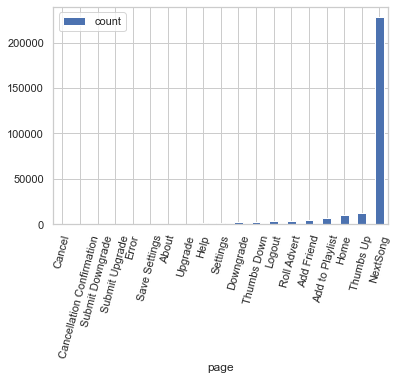

In [361]:
# unique pages and their counts
events.groupBy("page").count().orderBy('count').toPandas().plot(x="page", y="count", kind='bar', rot=75)

#### 1. Auth

In [362]:
# unique auth and their counts
events.groupBy('auth').count().orderBy('count').show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



In [363]:
# taking a look at what 'Cancelled' auth events look like as its the same number as 'Cancellation Confirm' page events
events.filter(events.auth == 'Cancelled').show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|               time|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|2018-10-07 21:26:30|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537

In [364]:
events.filter(events.auth == 'Cancelled').groupBy(['page', 'userId']).count().count() # 52 cancellation events

52

### Get churned users

In [365]:
# Cancelled value in auth column seems to appear with cancellation confirmation
# 2 ways I can define churn
# 1) I can create a lambda function to flag cancellation events with 1 
#    then apply max window over user to get churned users OR
# 2) use the dataframe below to left join 'events' to this 'churned_users' 
#    and keep the count value as churned column

# grouping by page or not yeilds the same set of userIds
churned_users = events.filter(events.auth == 'Cancelled').groupBy(['page', 'userId']).count()

In [366]:
get_churned = udf(lambda x: True if 'Cancellation Confirmation' in x else False)

##### Define Churn

In [371]:
# using the first method, we first left join churned users as 'b' with events as 'a' on userId column
# we then select all columns from the left table, i.e. events, and only the count column from right table
# finally we rename count as churned and replace the unmatched rows with 0s into 'events_w_churn'
events_w_churn = events.alias('a').join(churned_users.alias('b'), col('a.userId') == col('b.userId'),  how='left')\
.select([col('a.'+xx) for xx in events.columns] + [col('b.count')])\
.withColumnRenamed('count', 'churned').fillna({'churned': 0})

In [372]:
# alternative method: Not needed
churned_users2 = events.groupBy('userId').agg((f.collect_set('page')).alias('pages'))
churned_users2 = churned_users2.withColumn('churned', get_churned(churned_users2.pages))
churned_users2.groupBy('churned').count().toPandas()

,churned,count
0,false,173
1,true,52


In [373]:
# During EDA, I wanted to go column by column before defining churn 
# but the "auth column" and its unique values led me to define churn
# continuing the exploration we can now look at each column and
# its impact on churn.

#### 2. Registration and times

In [374]:
# Now that we have defined churn and before exploring more columns
# we will now look at what duration of data do we have
#    close together, wide spread, registrations, user lengths etc...

In [375]:
events_w_churn = events_w_churn.withColumn('reg_time', get_time('registration'))

In [376]:
# All our registrations range between 3rd March 2018 to 26th Nov 2018
events_w_churn.groupBy(to_date('reg_time').alias('date')).count().sort('count').select(min("date"), max("date")).show(1)

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-03-18|2018-11-26|
+----------+----------+



In [377]:
# All our events range between 1st Oct 2018 to 3rd Dec 2018
events_w_churn.groupBy(to_date('time').alias('date')).count().sort('count').select(min("date"), max("date")).show(1)

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-10-01|2018-12-03|
+----------+----------+



In [378]:
# Save the data for other uses
# events_w_churn.toPandas().to_csv('clean_events.csv')

##### View daily events

[Text(0, 0, '2018-10-01'),
 Text(1, 0, '2018-10-02'),
 Text(2, 0, '2018-10-03'),
 Text(3, 0, '2018-10-04'),
 Text(4, 0, '2018-10-05'),
 Text(5, 0, '2018-10-06'),
 Text(6, 0, '2018-10-07'),
 Text(7, 0, '2018-10-08'),
 Text(8, 0, '2018-10-09'),
 Text(9, 0, '2018-10-10'),
 Text(10, 0, '2018-10-11'),
 Text(11, 0, '2018-10-12'),
 Text(12, 0, '2018-10-13'),
 Text(13, 0, '2018-10-14'),
 Text(14, 0, '2018-10-15'),
 Text(15, 0, '2018-10-16'),
 Text(16, 0, '2018-10-17'),
 Text(17, 0, '2018-10-18'),
 Text(18, 0, '2018-10-19'),
 Text(19, 0, '2018-10-20'),
 Text(20, 0, '2018-10-21'),
 Text(21, 0, '2018-10-22'),
 Text(22, 0, '2018-10-23'),
 Text(23, 0, '2018-10-24'),
 Text(24, 0, '2018-10-25'),
 Text(25, 0, '2018-10-26'),
 Text(26, 0, '2018-10-27'),
 Text(27, 0, '2018-10-28'),
 Text(28, 0, '2018-10-29'),
 Text(29, 0, '2018-10-30'),
 Text(30, 0, '2018-10-31'),
 Text(31, 0, '2018-11-01'),
 Text(32, 0, '2018-11-02'),
 Text(33, 0, '2018-11-03'),
 Text(34, 0, '2018-11-04'),
 Text(35, 0, '2018-11-05'),
 T

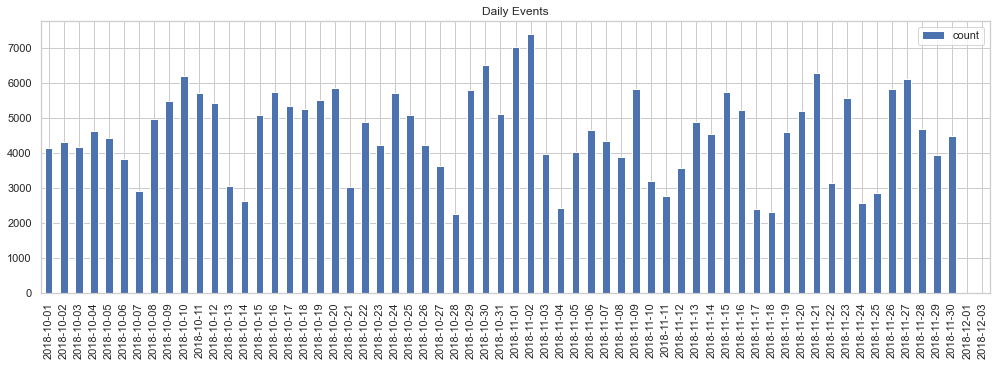

In [380]:
daily_events_pd = events_w_churn.groupBy(to_date('time').alias('date')).count().sort('date').toPandas()
ax = daily_events_pd.plot(kind='bar',figsize=(17,5), title='Daily Events')
ax.set_xticklabels(daily_events_pd['date'].tolist())

##### Create days since registration and total days on sparkify columns

In [381]:
# In addition to churned, lets add the lifetime column which will be max event time - reg time for each user

# add days_since_registration column for each event
events_w_churn = events_w_churn.withColumn('days_since_registration',f.round((events_w_churn.ts-events_w_churn.registration)/1000/3600/24))

# create a window over each user
user_window = Window.partitionBy("userId")

# create a column to choose days_since_registration over each window 
events_w_churn = events_w_churn.withColumn('total_days_on_sparkify', f.round(max(events_w_churn.days_since_registration).over(user_window), 0))

In [382]:
# We can see that the average time spent on the service for churned users is considerable less
events_w_churn \
    .select('churned','total_days_on_sparkify') \
    .groupBy('churned') \
    .agg({'total_days_on_sparkify':'avg'}).show()

+-------+---------------------------+
|churned|avg(total_days_on_sparkify)|
+-------+---------------------------+
|      0|          93.08523725834797|
|      1|          67.61505884450784|
+-------+---------------------------+



#### gender

<AxesSubplot:xlabel='gender', ylabel='count'>

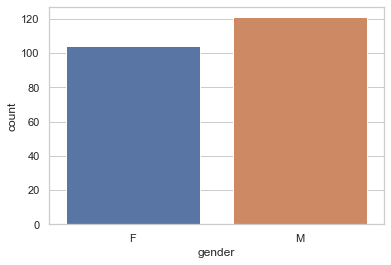

In [383]:
sns.barplot(x='gender',y='count',data=events_w_churn.groupBy('gender').agg(countDistinct('userId').alias('count')).toPandas())

<AxesSubplot:xlabel='churned', ylabel='count'>

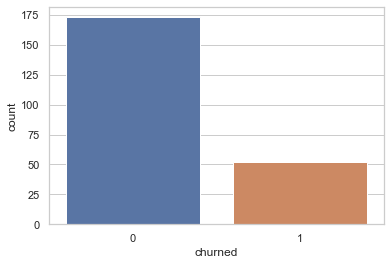

In [384]:
sns.barplot(x='churned', y='count', data = events_w_churn.select('userId', 'churned').groupBy('churned').agg(countDistinct('userId').alias('count')).toPandas())

<AxesSubplot:xlabel='churned', ylabel='count'>

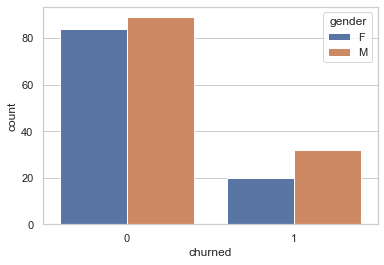

In [385]:
sns.barplot(x='churned', y='count', hue='gender', data=events_w_churn.select('userId', 'churned', 'gender').groupBy('gender', 'churned').agg(countDistinct('userId').alias('count')).toPandas())

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [386]:
events_w_churn.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- churned: long (nullable = false)
 |-- reg_time: string (nullable = true)
 |-- days_since_registration: double (nullable = true)
 |-- total_days_on_sparkify: double (nullable = true)



In [387]:
events.groupBy("page").count().orderBy('count').show()

+--------------------+------+
|                page| count|
+--------------------+------+
|Cancellation Conf...|    52|
|              Cancel|    52|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|               Error|   252|
|       Save Settings|   310|
|               About|   495|
|             Upgrade|   499|
|                Help|  1454|
|            Settings|  1514|
|           Downgrade|  2055|
|         Thumbs Down|  2546|
|              Logout|  3226|
|         Roll Advert|  3933|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|                Home| 10082|
|           Thumbs Up| 12551|
|            NextSong|228108|
+--------------------+------+



In [388]:
# Feature generation: number of unique pages visited 

events_w_features = events_w_churn.withColumn('total_unique_pages_visited', f.size(f.collect_set('page').over(user_window)))\
                            .withColumn('total_events', f.count('ts').over(user_window)) \
                            .withColumn('total_artists_heard', f.size(f.collect_set('artist').over(user_window))) \
                            .withColumn('total_unique_songs_heard', f.size(f.collect_set('song').over(user_window))) \
                            .withColumn('is_next_song', f.when(events_w_churn.page=='NextSong', 1).otherwise(0))\
                            .withColumn('is_thumbs_up', f.when(events_w_churn.page=='Thumbs Up', 1).otherwise(0)) \
                            .withColumn('is_thumbs_down', f.when(events_w_churn.page=='Thumbs Down', 1).otherwise(0)) \
                            .withColumn('is_settings', f.when(events_w_churn.page=='Settings', 1).otherwise(0)) \
                            .withColumn('is_add_friend', f.when(events_w_churn.page=='Add Friend', 1).otherwise(0))\
                            .withColumn('is_add_to_playlist', f.when(events_w_churn.page=='Add to Playlist',1).otherwise(0))\
                            .withColumn('is_about', f.when(events_w_churn.page=='About',1).otherwise(0))\
                            .withColumn('is_help', f.when(events_w_churn.page=='Help',1).otherwise(0))\
                            .withColumn('is_error', f.when(events_w_churn.page=='Error',1).otherwise(0))

# add average number of songs per session for each user


In [389]:
events_w_features.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- churned: long (nullable = false)
 |-- reg_time: string (nullable = true)
 |-- days_since_registration: double (nullable = true)
 |-- total_days_on_sparkify: double (nullable = true)
 |-- total_unique_pages_visited: integer (nullable = false)
 |-- total_events: long

In [390]:
# drop extra columns that are no longer needed or 
# will not be included in this modelling iteration

drop_list = ['artist', 'auth', 'firstName', 
            'itemInSession', 'lastName', 'location',
            'method', 'registration', 'song',
            'status', 'ts', 'userAgent']

events_w_features = events_w_features.drop(*drop_list)

In [391]:
events_w_features = events_w_features.groupBy("userID").agg(
    f.first("churned").alias("label"),
    f.first("gender").alias("gender"),
    f.avg("length").alias("avg_length"),
    f.min("length").alias("min_length"),
    f.max("length").alias("max_length"),
    f.first("level").alias("subscription_level"),
    f.min("time").alias("first_event_time"),
    f.max("time").alias("last_event_time"),
    f.first("reg_time").alias("reg_time"),
    f.first("days_since_registration").alias("days_since_registration"),  
    f.first("total_days_on_sparkify").alias("total_days_on_sparkify"),
    f.first("total_unique_pages_visited").alias("total_unique_pages_visited"),
    f.first("total_events").alias("total_events"),
    f.first("total_artists_heard").alias("total_artists_heard"),
    f.first("total_unique_songs_heard").alias("total_unique_songs_heard"),
    f.sum("is_next_song").alias("total_next_song_events"),
    f.sum("is_thumbs_up").alias("total_thumbs_up_events"),
    f.sum("is_thumbs_down").alias("total_thumbs_down_events"),
    f.sum("is_settings").alias("total_settings_events"),
    f.sum("is_add_friend").alias("total_add_friend_events"),
    f.sum("is_add_to_playlist").alias("total_add_to_playlist_events"),
    f.sum("is_about").alias("total_about_events"),
    f.sum("is_error").alias("total_error_events"),
    f.sum("is_help").alias("total_help_events")
)

In [392]:
df = events_w_features
df = df.withColumn('days_bw_first_last_event', f.datediff('last_event_time', 'first_event_time'))\
        .drop('last_event_time')\
        .drop('first_event_time')\
        .drop('reg_time')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [393]:
df.printSchema()

root
 |-- userID: string (nullable = true)
 |-- label: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- avg_length: double (nullable = true)
 |-- min_length: double (nullable = true)
 |-- max_length: double (nullable = true)
 |-- subscription_level: string (nullable = true)
 |-- days_since_registration: double (nullable = true)
 |-- total_days_on_sparkify: double (nullable = true)
 |-- total_unique_pages_visited: integer (nullable = true)
 |-- total_events: long (nullable = true)
 |-- total_artists_heard: integer (nullable = true)
 |-- total_unique_songs_heard: integer (nullable = true)
 |-- total_next_song_events: long (nullable = true)
 |-- total_thumbs_up_events: long (nullable = true)
 |-- total_thumbs_down_events: long (nullable = true)
 |-- total_settings_events: long (nullable = true)
 |-- total_add_friend_events: long (nullable = true)
 |-- total_add_to_playlist_events: long (nullable = true)
 |-- total_about_events: long (nullable = true)
 |-- total_error_even

In [394]:
categorical_features = ['gender', 'subscription_level']
numerical_features = set(df.columns)-set(categorical_features)

### Data prep pipline

In [421]:
input_cols = ['avg_length',
 'min_length',
 'max_length',
 'days_since_registration',
 'total_days_on_sparkify',
 'total_unique_pages_visited',
 'total_events',
 'total_artists_heard',
 'total_unique_songs_heard',
 'total_next_song_events',
 'total_thumbs_up_events',
 'total_thumbs_down_events',
 'total_settings_events',
 'total_add_friend_events',
 'total_add_to_playlist_events',
 'total_about_events',
 'total_error_events',
 'total_help_events',
 'days_bw_first_last_event'
] + categorical_features

# convert categorical feature to feature indexes
gender_indexer = StringIndexer(inputCol='gender', outputCol='gender_index')
subcription_indexer = StringIndexer(inputCol='subscription_level', outputCol='subscription_level_index')
input_cols.append('gender_index')
input_cols.remove('gender')
input_cols.append('subscription_level_index')
input_cols.remove('subscription_level')
assembler = VectorAssembler(inputCols= input_cols, outputCol="feature_vector")
input_cols.append('feature_vector')
scaler = StandardScaler(inputCol="feature_vector", outputCol="scaled_feature_vector")
data_prep_pipline = Pipeline(stages=[gender_indexer, subcription_indexer, assembler, scaler])

In [431]:
scaled_indexed_df = data_prep_pipline.fit(df).transform(df).drop(*input_cols)
scaled_indexed_df = scaled_indexed_df.drop(*['gender','subscription_level'])

In [432]:
scaled_indexed_df.printSchema()

root
 |-- userID: string (nullable = true)
 |-- label: long (nullable = true)
 |-- scaled_feature_vector: vector (nullable = true)



### Train model

In [433]:
scores = []

In [434]:
# split data into train and test
train, test = scaled_indexed_df.randomSplit([0.8,0.2], seed=6)

# create an evaluator for measring the f1 score for each model
evaluator = MulticlassClassificationEvaluator(metricName="f1")

#### Logistic Regression

First cell of each modeling step was the first iteration. It prepares models using paramgrid and cross validator to determine best params. However, after spending some time the second approach (in the second cell) is much cleaner, faster and uses default params which are often good place to start.

In [151]:
lr = LogisticRegression(labelCol='label', featuresCol='scaled_feature_vector',
                        maxIter=10, regParam=0.0)

evaluator = MulticlassClassificationEvaluator(metricName="f1")

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train)
cvModel.avgMetrics

[0.8851631063157412, 0.8449030665199191]

In [435]:
# create pipeline with logistic regression classifier, using default settings, train model and measure score against test
logistic_regression_classifier = LogisticRegression(featuresCol='scaled_feature_vector', labelCol='label')
pipeline = Pipeline(stages=[logistic_regression_classifier])
model = pipeline.fit(train)
preds = model.transform(test)
scores.append(['Logistic Regression', evaluator.evaluate(preds)])

#### Random Forest Classifier

In [152]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_feature_vector", numTrees=10)

evaluator_rf = MulticlassClassificationEvaluator(metricName="f1")

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees,[5, 10]) \
    .build()

crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=evaluator_rf,
                          numFolds=3)

cvModel_rf = crossval_rf.fit(train)
cvModel_rf.avgMetrics

[0.8104051224794977, 0.8385750314416927]

In [439]:
random_forest_classifier = RandomForestClassifier(featuresCol='scaled_feature_vector', labelCol='label')
pipeline = Pipeline(stages=[random_forest_classifier])
model = pipeline.fit(train)
preds = model.transform(test)
scores.append(['Random Forest', evaluator.evaluate(preds)])

#### Gradient Boosted Trees

In [153]:
gbt = GBTClassifier(labelCol="label", featuresCol="scaled_feature_vector", maxDepth=5)

evaluator_gbt = MulticlassClassificationEvaluator(metricName="f1")

paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=evaluator_gbt,
                          numFolds=3)

cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics

[0.8147919627924023, 0.8024057396782098]

In [440]:
gbt_classifier = GBTClassifier(featuresCol='scaled_feature_vector', labelCol='label')
pipeline = Pipeline(stages=[gbt_classifier])
model = pipeline.fit(train)
preds = model.transform(test)
scores.append(['Gradient Boosted Trees', evaluator.evaluate(preds)])

In [441]:
# look what predictions look like
preds.show()

+------+-----+---------------------+--------------------+--------------------+----------+
|userID|label|scaled_feature_vector|       rawPrediction|         probability|prediction|
+------+-----+---------------------+--------------------+--------------------+----------+
|    54|    1| [42.1394729204961...|[-1.8604490197620...|[0.02363984163614...|       1.0|
|   101|    1| [41.9073439488336...|[0.45649799727501...|[0.71361284446584...|       0.0|
|    69|    0| [42.7947823848259...|[1.55302413777927...|[0.95714154220766...|       0.0|
|200010|    0| [43.1586924009339...|[-1.0545089229382...|[0.10822341908039...|       1.0|
|   133|    0| [42.2279952769768...|[0.68864940218081...|[0.79855682600439...|       0.0|
|300013|    0| [42.6577069364212...|[1.54451308925540...|[0.95643780926350...|       0.0|
|    47|    0| [40.8065279812981...|[1.43120710500343...|[0.94595685289617...|       0.0|
|     5|    0| [41.3167942597854...|[-0.8120958266589...|[0.16462760092486...|       1.0|
|    70|  

<AxesSubplot:xlabel='Classifier', ylabel='F1 Score'>

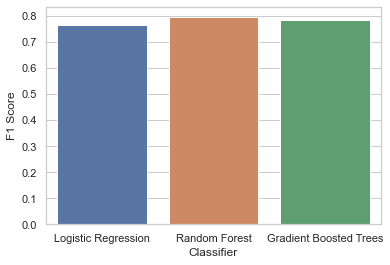

In [442]:
scores_df = pd.DataFrame(scores, columns=['Classifier', 'F1 Score'])
sns.barplot(x='Classifier',y='F1 Score',data=scores_df)

In [443]:
scores

[['Logistic Regression', 0.7654006720293248],
 ['Random Forest', 0.7952380952380952],
 ['Gradient Boosted Trees', 0.7839677563815495]]

##### Confusion matrix for best base model

In [258]:
# ref: https://stackoverflow.com/questions/58404845/confusion-matrix-to-get-precsion-recall-f1score

# select only prediction and label columns
preds_and_labels = preds.select(['prediction','label'])

preds_and_labels = preds_and_labels.withColumn('label', f.col('label').cast(FloatType())).sort(f.desc('prediction'))

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[22.  2.]
 [ 5. 13.]]


<AxesSubplot:>

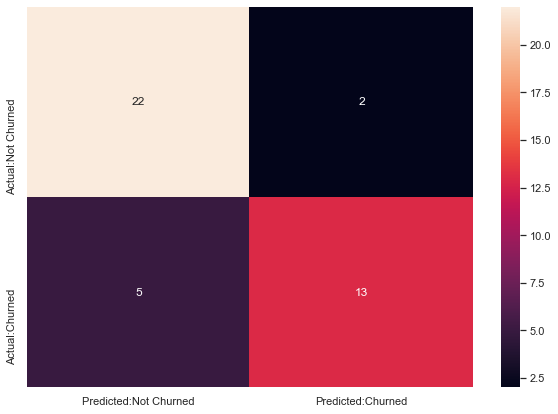

In [268]:
df_cm = pd.DataFrame(metrics.confusionMatrix().toArray(), index = [i for i in ['Actual:Not Churned', 'Actual:Churned']],
                  columns = [i for i in ["Predicted:Not Churned", "Predicted:Churned"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

#### Tuning

In [277]:
# lets recreate our best model: GBT

gbt_classifier = GBTClassifier(featuresCol='scaled_feature_vector', labelCol='label')

# embed it in a pipeline

optimisation_pipeline = Pipeline(stages=[gbt_classifier])

# try some params
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt_classifier.maxDepth,[2, 5, 10]) \
    .addGrid(gbt_classifier.maxBins,[5,10]) \
    .addGrid(gbt_classifier.maxIter,[5,10,50]) \
    .build()

crossval = CrossValidator(estimator=optimisation_pipeline,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=evaluator,
                          numFolds=3)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cvModel.transform(test)

In [347]:
#select only prediction and label columns
tuned_preds = prediction.select(['prediction','label'])

tuned_preds = tuned_preds.withColumn('label', f.col('label').cast(FloatType())).sort(f.desc('prediction'))

metrics = MulticlassMetrics(tuned_preds.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[24.  0.]
 [ 9.  9.]]


<AxesSubplot:>

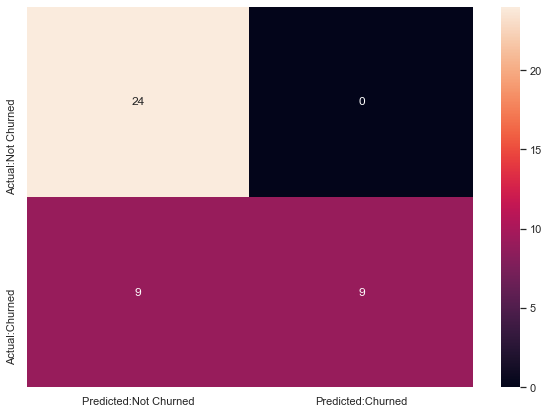

In [348]:
df_cm = pd.DataFrame(metrics.confusionMatrix().toArray(), index = [i for i in ['Actual:Not Churned', 'Actual:Churned']],
                  columns = [i for i in ["Predicted:Not Churned", "Predicted:Churned"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [288]:
# append the scores for comparison
scores.append(['GBT with param tuning', evaluator.evaluate(prediction)])

In [337]:
scores

[['Logistic Regression', 0.7959183673469388],
 ['Random Forest', 0.7448979591836735],
 ['Gradient Boosted Trees', 0.8306595365418894],
 ['GBT with param tuning', 0.7669172932330828]]

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Gradient Boosted Trees'),
  Text(3, 0, 'GBT with param tuning')])

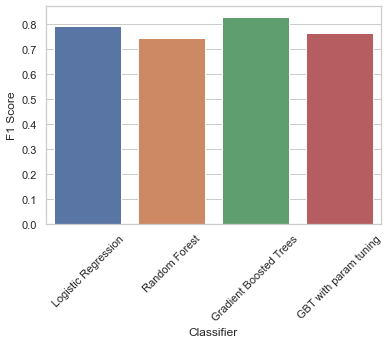

In [338]:
scores_df = pd.DataFrame(scores, columns=['Classifier', 'F1 Score'])
sns.barplot(x='Classifier',y='F1 Score',data=scores_df)
plt.xticks(rotation=45)

In [341]:
feat_imp_base_model = DenseVector(model.stages[0].featureImportances).values
feat_imp_tuned_model = DenseVector(cvModel.bestModel.stages[0].featureImportances).values

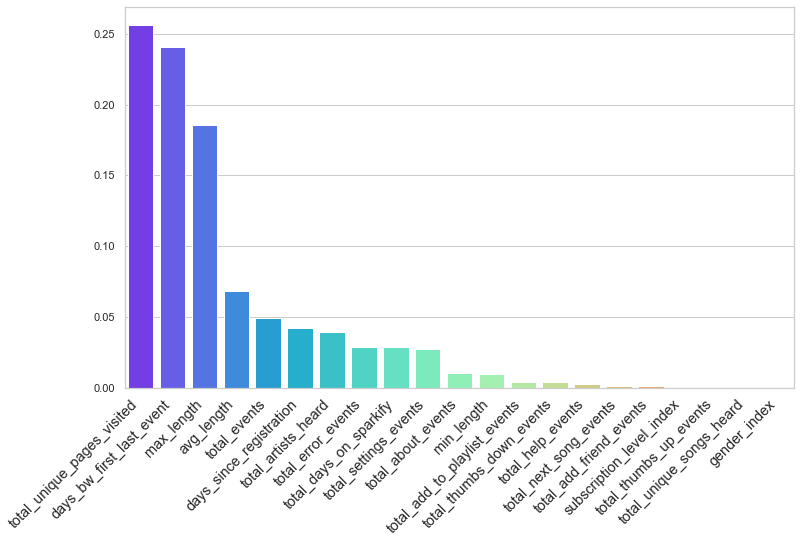

In [342]:
# http://scienceoss.com/sort-one-list-by-another-list/
feat_imp_sorted = np.array(feat_imp_base_model)
pred_cols_sorted = np.array(input_cols)
inds = np.flipud(feat_imp_sorted.argsort())
pred_cols_sorted = pred_cols_sorted[inds]
feat_imp_sorted = feat_imp_sorted[inds]

plt.figure(figsize=(12,7))
chart = sns.barplot(x=pred_cols_sorted,y=feat_imp_sorted,palette='rainbow')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'
)
plt.show()

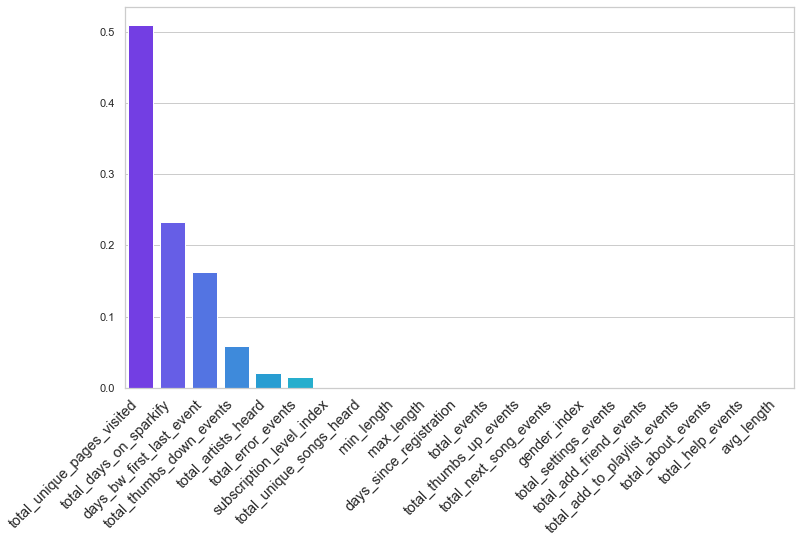

In [343]:
# http://scienceoss.com/sort-one-list-by-another-list/
feat_imp_sorted = np.array(feat_imp_tuned_model)
pred_cols_sorted = np.array(input_cols)
inds = np.flipud(feat_imp_sorted.argsort())
pred_cols_sorted = pred_cols_sorted[inds]
feat_imp_sorted = feat_imp_sorted[inds]

plt.figure(figsize=(12,7))
chart = sns.barplot(x=pred_cols_sorted,y=feat_imp_sorted,palette='rainbow')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'
)
plt.show()

In [346]:
# check what were the default parameters that gave the best f1 score
model.stages[0].extractParamMap()

{Param(parent='GBTClassifier_d2d12d944b51', name='featuresCol', doc='features column name.'): 'scaled_feature_vector',
 Param(parent='GBTClassifier_d2d12d944b51', name='labelCol', doc='label column name.'): 'label',
 Param(parent='GBTClassifier_d2d12d944b51', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='GBTClassifier_d2d12d944b51', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
 Param(parent='GBTClassifier_d2d12d944b51', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='GBTClassifier_d2d12d944b51', name='seed', doc='random seed.'): -4820642401867922123,
 Param(parent='GBTClassifier_d2d12d944b51', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match i

In [350]:
cvModel.bestModel.stages[0].extractParamMap()

{Param(parent='GBTClassifier_5d8632ce62bd', name='featuresCol', doc='features column name.'): 'scaled_feature_vector',
 Param(parent='GBTClassifier_5d8632ce62bd', name='labelCol', doc='label column name.'): 'label',
 Param(parent='GBTClassifier_5d8632ce62bd', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='GBTClassifier_5d8632ce62bd', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
 Param(parent='GBTClassifier_5d8632ce62bd', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='GBTClassifier_5d8632ce62bd', name='seed', doc='random seed.'): -4820642401867922123,
 Param(parent='GBTClassifier_5d8632ce62bd', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match i

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.